In [174]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm
import torch
from weaver.nn.model.ParticleTransformer import ParticleTransformer
from weaver.utils.logger import _logger
import torch.optim as optim


In [175]:
def build_features_and_labels(tree, transform_features=True):
    
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log', 
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)
    
    return out

In [176]:
def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

In [177]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


In [178]:
tree = uproot.open('JetClass_example_100k.root')['tree']

In [179]:
table = build_features_and_labels(tree)


In [189]:
x_particles = table['pf_features']
x_jets = table['pf_vectors']
y = table['label']
x_points = table['pf_points']
x_mask = table['pf_mask']

In [190]:
x_jets.shape

(100000, 4, 128)

In [191]:
x_jets.shape

(100000, 4, 128)

In [192]:
r_indexes = np.arange(len(x_particles))
np.random.shuffle(r_indexes)


In [193]:
x_particles_train=x_particles[r_indexes][0:10000]
x_jets_train=x_jets[r_indexes][0:10000]
y_train=y[r_indexes][0:10000]
x_points_train=x_points[r_indexes][0:10000]
x_mask_train=x_mask[r_indexes][0:10000]

In [194]:
x_part_test=x_particles[r_indexes][20000:21000]
x_jet_test=x_jets[r_indexes][20000:21000]
y_test=y[r_indexes][20000:21000]
x_points_test=x_points[r_indexes][20000:21000]
x_mask_test=x_mask[r_indexes][20000:21000]

In [186]:
x_points.shape

(100000, 2, 128)

In [187]:
x_particles_train.shape

(10000, 17, 128)

In [188]:
x_part_test = x_particles[1000:2000]
for b in range(9):
    x_part_test = np.append(x_part_test, x_particles[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

In [126]:
y_test = y[1000:2000]
for b in range(9):
    y_test = np.append(y_test, y[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

In [127]:
X_train_P = x_particles[2000:3000]
for b in range(9):
    x_part_test = np.append(X_train_P, x_particles[(b+1)*10000+4000:(b+1)*10000+5000], axis = 0)
y_train = y[2000:3000]
for b in range(9):
    y_train = np.append(y_train, y[(b+1)*10000+4000:(b+1)*10000+5000], axis = 0)
X_train_J = x_jets[2000:3000]
for b in range(9):
    X_train_J = np.append(X_train_J, x_jets[(b+1)*10000+4000:(b+1)*10000+5000], axis = 0)

In [128]:
x_jet_test = x_jets[1000:2000]
for b in range(9):
    x_jet_test = np.append(x_jet_test, x_jets[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

In [129]:
x_mask_test = x_mask[1000:2000]
for b in range(9):
    x_mask_test = np.append(x_mask_test, x_mask[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

In [130]:
x_points_test = x_points[1000:2000]
for b in range(9):
    x_points_test = np.append(x_points_test, x_points[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

In [131]:
x_part_test1 = x_particles[100:200]
for b in range(9):
    x_part_test1 = np.append(x_part_test1, x_particles[(b+1)*10000+100:(b+1)*10000+200], axis = 0)
y_test1= y[100:200]
for b in range(9):
    y_test1 = np.append(y_test1, y[(b+1)*10000+100:(b+1)*10000+200], axis = 0)
x_jet_test1 = x_jets[100:200]
for b in range(9):
    x_jet_test1 = np.append(x_jet_test1, x_jets[(b+1)*10000+100:(b+1)*10000+200], axis = 0)
x_mask_test1 = x_mask[100:200]
for b in range(9):
    x_mask_test1 = np.append(x_mask_test1, x_mask[(b+1)*10000+100:(b+1)*10000+200], axis = 0)
x_points_test1 = x_points[100:200]
for b in range(9):
    x_points_test1 = np.append(x_points_test1, x_points[(b+1)*10000+100:(b+1)*10000+200], axis = 0)

In [195]:
loss_fn = torch.nn.CrossEntropyLoss()


In [229]:
class ParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = ParticleTransformer(**kwargs)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        return self.mod(features, v=lorentz_vectors, mask=mask)
    
    


def get_model(**kwargs):

    cfg = dict(
        input_dim=17,
        num_classes=10,
        # network configurations
        pair_input_dim=4,
        use_pre_activation_pair=False,
        embed_dims=[32, 32, 32],
        pair_embed_dims=[32, 32, 32],
        num_heads=2,
        num_layers=2,
        num_cls_layers=1,
        block_params=None,
        cls_block_params={'dropout': 0.2, 'attn_dropout': 0.2, 'activation_dropout': 0.2},
        fc_params=[],
        activation='gelu',
        # misc
        trim=True,
        for_inference=False,
    )
    cfg.update(**kwargs)
    _logger.info('Model config: %s' % str(cfg))

    model = ParticleTransformerWrapper(**cfg)

    model_info = {

    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [230]:
model, modInf = get_model()

In [231]:
total_params = sum(p.numel() for p in model.parameters())


In [232]:
total_params

45026

In [233]:
model

ParticleTransformerWrapper(
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17, out_features=32, bias=True)
        (2): GELU(approximate='none')
        (3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (4): Linear(in_features=32, out_features=32, bias=True)
        (5): GELU(approximate='none')
        (6): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (7): Linear(in_features=32, out_features=32, bias=True)
        (8): GELU(approximate='none')
      )
    )
    (pair_embed): PairEmbed(
      (embed): Sequential(
        (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(32, eps=1e-05, 

In [234]:
from torch.utils.data import Dataset, DataLoader


In [235]:
learning_rate = 1e-4
dataloader = DataLoader(x_particles_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
ydataloader = DataLoader(y_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xjdataloader = DataLoader(x_jets_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xpointloader = DataLoader(x_points_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xmaskloader = DataLoader(x_mask_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [236]:
loss_fn = torch.nn.CrossEntropyLoss()


In [237]:
model.aux_logits=False

model()

In [238]:
trainloss = np.zeros(100)
valloss = np.zeros(100)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for t in range(100):
    for x,y,z,a,b in zip(dataloader,ydataloader, xjdataloader,xpointloader,xmaskloader):
        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __c|all__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        
        y_pred = model(a.float(), x.float(), z.float(), b.float())
        
        loss = loss_fn(y_pred[0], torch.max(y.float(),1)[1])

        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        trainloss[t] = loss
        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        optimizer.step()
    with torch.no_grad():
        y_pred= model(torch.from_numpy(x_points_test),torch.from_numpy(x_part_test),torch.from_numpy(x_jet_test),torch.from_numpy(x_mask_test))
    yloss = loss_fn(y_pred[0], torch.max(torch.from_numpy(y_test),1)[1])
    valloss[t] = yloss
    print('Epoch' +' ' +str(t+1) + ' Train Loss:' +str(trainloss[t]))
    print('        ' + 'Val Loss:' + str(valloss[t]))

/Users/anrunw/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1 Train Loss:2.1094253063201904
        Val Loss:2.0002057552337646
Epoch 2 Train Loss:1.551548719406128
        Val Loss:1.5807982683181763
Epoch 3 Train Loss:1.3621281385421753
        Val Loss:1.418613076210022
Epoch 4 Train Loss:1.3010451793670654
        Val Loss:1.3264929056167603
Epoch 5 Train Loss:1.457913875579834
        Val Loss:1.2915990352630615
Epoch 6 Train Loss:1.2710421085357666
        Val Loss:1.2185848951339722
Epoch 7 Train Loss:1.2718263864517212
        Val Loss:1.2064956426620483
Epoch 8 Train Loss:1.3231738805770874
        Val Loss:1.1839382648468018
Epoch 9 Train Loss:1.314062237739563
        Val Loss:1.1653847694396973
Epoch 10 Train Loss:1.2853273153305054
        Val Loss:1.1377627849578857
Epoch 11 Train Loss:1.2395716905593872
        Val Loss:1.1539322137832642
Epoch 12 Train Loss:1.3770785331726074
        Val Loss:1.1353561878204346
Epoch 13 Train Loss:1.381431221961975
        Val Loss:1.1558339595794678
Epoch 14 Train Loss:1.3313961029052734


In [239]:
torch.save(model,'torchModelNoPairParticleTransformer')



In [222]:
import matplotlib.pyplot as plt

In [223]:
def learningCurve(trainloss,valloss):
    plt.figure(figsize=(10,8))
    plt.plot(trainloss)
    plt.plot(valloss)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

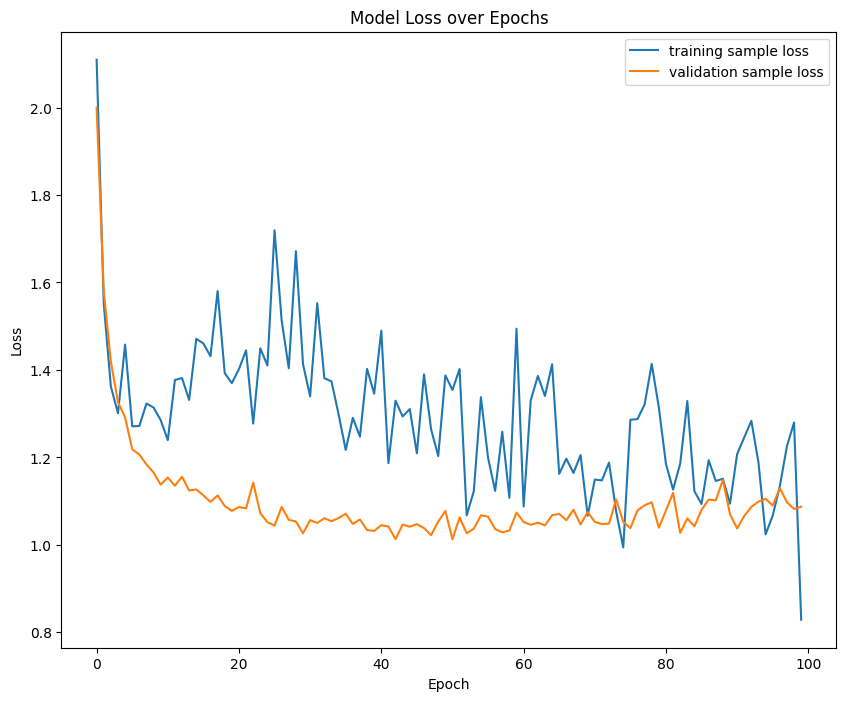

In [244]:
learningCurve(trainloss,valloss)


In [240]:
label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']


In [241]:
def makeRoc(features1,feat2,feat3,feat4, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model(torch.from_numpy(features1),torch.from_numpy(feat2),torch.from_numpy(feat3),torch.from_numpy(feat4))
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    g = labels_pred.detach().numpy()
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = g[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'Particle Transformer (No Pairs) ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

In [242]:
import pandas as pd

In [243]:
makeRoc(x_points_test,x_part_test,x_jet_test,x_mask_test,y_test,label_list, model)

AttributeError: 'tuple' object has no attribute 'detach'

<Figure size 1000x800 with 0 Axes>

tensor([[-1.1432,  4.1510,  2.3601,  ..., -2.8480,  1.3228, -7.0669],
        [ 0.8165, -3.0551, -0.5372,  ...,  5.8913, -1.9819, -4.4220],
        [ 0.9719,  1.4946,  2.1882,  ..., -1.4645,  5.8113, -2.8373],
        ...,
        [ 0.2844,  0.6145,  1.0169,  ..., -0.2602,  4.8016, -6.5349],
        [ 0.8572, -1.6650,  1.0813,  ..., -2.8066,  1.5701, -2.8870],
        [ 2.1971,  1.2499,  0.5237,  ..., -4.3074,  2.9996, -1.1027]],
       grad_fn=<AddmmBackward0>)

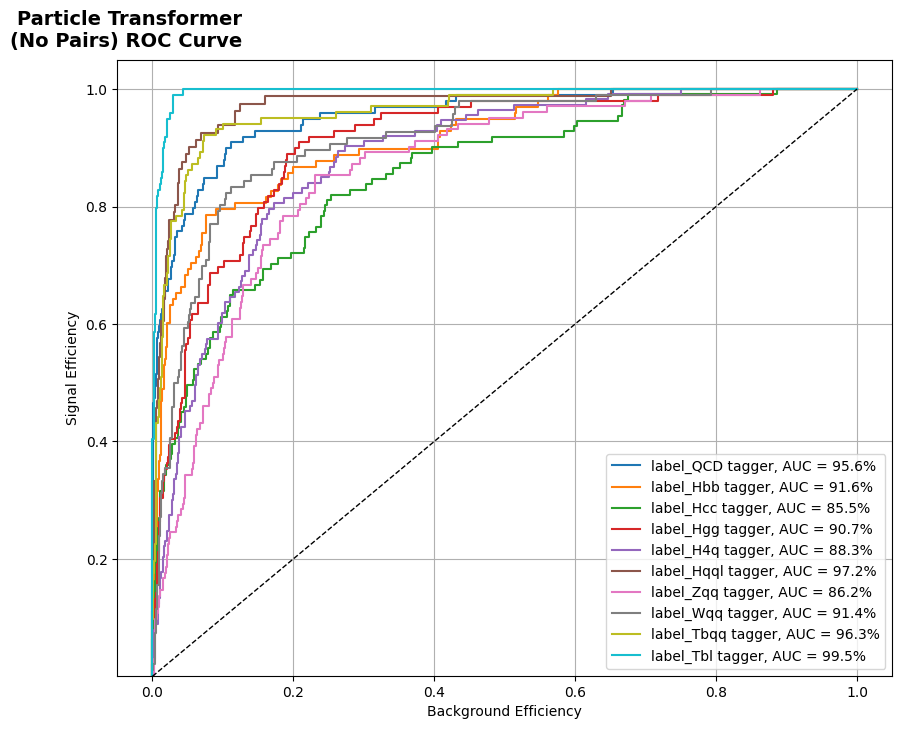

In [ ]:
makeRoc(x_points_test,x_part_test,x_jet_test,x_mask_test,y_test,label_list, model)